# 4: Real Data Mapping
We have achieved a low level form of particle tracking. Now the goal is to map the data and retrieve interesting trends.

In [2]:
# Needed to make animations real.
%matplotlib inline
#%matplotlib nbagg|
#%matplotlib widget

In [3]:
# General imports for math
import numpy.random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Imports to make animation work
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.path as path
from IPython.display import HTML

# Access graphing parameters
import matplotlib.mlab as mlb
from matplotlib import rc

In [5]:
# Advanced Math
from scipy import optimize as opt
from scipy.interpolate import interp1d
from scipy import stats as stats
from sklearn.preprocessing import normalize
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import io
from skimage import exposure
from skimage import data, io, segmentation, color
from skimage.future import graph
from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity

In [6]:
# General Diagnostics and other handy items
import math
import time
import os
import timeit
from timeit import default_timer as timer

# Trouble Shooting
#from pympler.classtracker import ClassTracker
#from pympler import tracker

In [7]:
# Graphing parameters for inline images.
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 2
#Graphing parameters that I can alter (Need to make this a full method at some point)
font = {
        'weight': 'bold',
        'size': 12,
        'family': 'serif',
        'serif': 'Times New Roman'}
rc('font', **font)
rc('xtick', labelsize = 30)
rc('ytick', labelsize = 30)
rc('lines', linewidth = 4)
rc('axes', linewidth = 4.5)
rc('text', usetex = 'False')
rc('animation', html = 'html5')
# Handy link about changing rc parameters https://matplotlib.org/users/customizing.html
bounding_box = [-1, -0.5, 2, 0.9] # Sets the bounds for the plots below

# Block of code to generate a unique spot to save everyting automatically
date = time.strftime("%Y_%m_%d") # Date string for dynamic saving.
vers = 'Real_Data_Mapping' # A string to denote a differen version for dynamic saving.
nb = 'nb4' # Number of the notebook for dynamic saving.
directory = './saved_outputs/'+date +'/'+nb+'/'+vers+'/'
if not os.path.exists(directory):
    os.makedirs(directory)
print directory
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

./saved_outputs/2019_04_23/nb4/Real_Data_Mapping/


In [8]:
# Boolean for saving results
save = False
pix2nm = 193.8 # Number of nanometers per pixel in these images
file_head_ZEB = '../movie_files/393P-ZEB1/'
file_head_normal = '../movie_files/393P-Vector/'
sample_names = ['393P-Vector_Rab5mCherry_1','393P-Vector_Rab5mCherry_2','393P-Vector_Rab5mCherry_1','393P-ZEB1_mCherry_1','393P-ZEB1_Rab5mCherry_2', '393P-ZEB1_Rab5mCherry_3']

In [10]:
# Declare troika experiment w/ specified sample
from troika_functions import *
print 'Running'
t_e = troikaExperiment(file_head_normal+sample_names[0]+'.tif', verbose = False, is_linking = True, track_time = True, frame_tolerance = 1)
start_time = timeit.default_timer()
for i in range(600):
    t_e.identifyParticles()
    t_e.nextFrame()
print (timeit.default_timer() - start_time)/60, 'minutes'

Running
mapParticles: Frame  1  of  600 mapped in  2.88725495338  seconds. 179  of  188  particles mapped.
mapParticles: Frame  2  of  600 mapped in  3.1457259655  seconds. 174  of  196  particles mapped.
mapParticles: Frame  3  of  600 mapped in  3.60131001472  seconds. 182  of  208  particles mapped.
mapParticles: Frame  4  of  600 mapped in  3.65854597092  seconds. 193  of  211  particles mapped.
mapParticles: Frame  5  of  600 mapped in  4.05334997177  seconds. 195  of  220  particles mapped.
mapParticles: Frame  6  of  600 mapped in  4.33109903336  seconds. 196  of  220  particles mapped.
mapParticles: Frame  7  of  600 mapped in  4.1050620079  seconds. 198  of  215  particles mapped.
mapParticles: Frame  8  of  600 mapped in  4.21728396416  seconds. 201  of  225  particles mapped.
mapParticles: Frame  9  of  600 mapped in  3.92478108406  seconds. 194  of  206  particles mapped.
mapParticles: Frame  10  of  600 mapped in  4.22870397568  seconds. 192  of  225  particles mapped.
map

In [11]:
len(t_e.getRealParticles())

7306

7306
1723


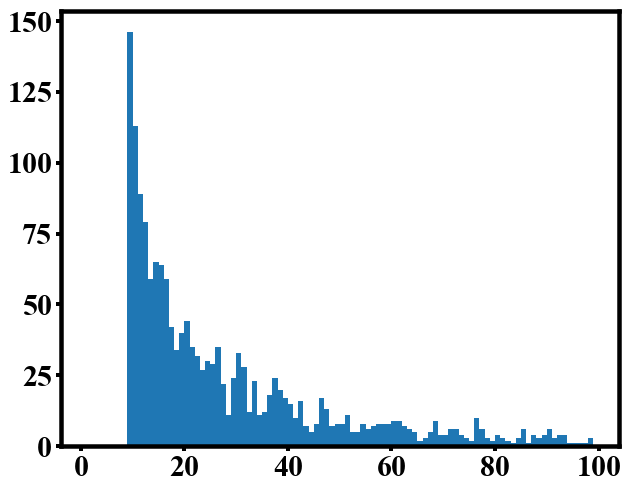

In [21]:
frame_counts = list()
print len(t_e.getRealParticles())
for i in t_e.getRealParticles():
    if type(t_e.particles[i]) is tuple:
        continue
    else:
        index = len(t_e.particles[i].frames)
        if index <= 8:
            continue
    frame_counts.append(index)
bins = np.arange(1, 100, 1)
plt.hist(frame_counts, bins)
print len(frame_counts)

In [85]:
part = t_e.getParticle((0,9))

In [86]:
np.sqrt(part.calcMSD())

1.348399724926484

In [87]:
part.raw_x_pos

array([200., 200., 200., 200., 200., 200., 198., 199., 199., 200., 200.,
       201., 199., 200., 200., 201., 200., 200., 199., 200., 200., 200.])

In [88]:
part.raw_y_pos

array([155., 155., 155., 155., 156., 157., 157., 154., 154., 154., 154.,
       154., 158., 156., 154., 154., 154., 155., 156., 156., 155., 154.])

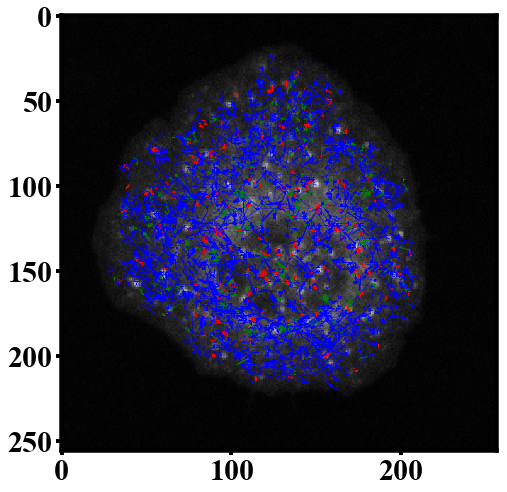

In [13]:
plt.figure(figsize = (8,8))
for i in t_e.getRealParticles():
    part = t_e.getParticle(i)
    x = part.raw_x_pos
    if len(x) < 10:
        continue
    y = part.raw_y_pos
    color = 'black'
    if part.calcMSD() < 2:
        color = 'red'
    elif part.calcMSD() < 5:
        color = 'green'
    else:
        color = 'blue'
    plt.plot(y, x, color = color, linewidth = 0.5)
plt.imshow(t_e.getFrame(0))

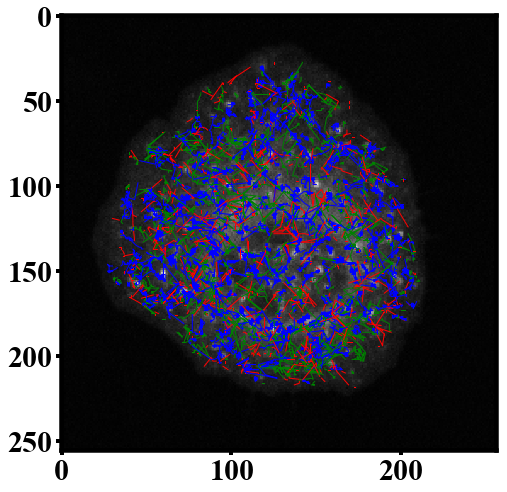

In [90]:
plt.figure(figsize = (8,8))
for i in t_e.getRealParticles():
    part = t_e.getParticle(i)
    x = part.raw_x_pos
    y = part.raw_y_pos
    color = 'black'
    if len(x) < 5:
        color = 'red'
    elif len(x) < 18:
        color = 'green'
    else:
        color = 'blue'
    plt.plot(y, x, color = color, linewidth = 1)
plt.imshow(t_e.getFrame(0))

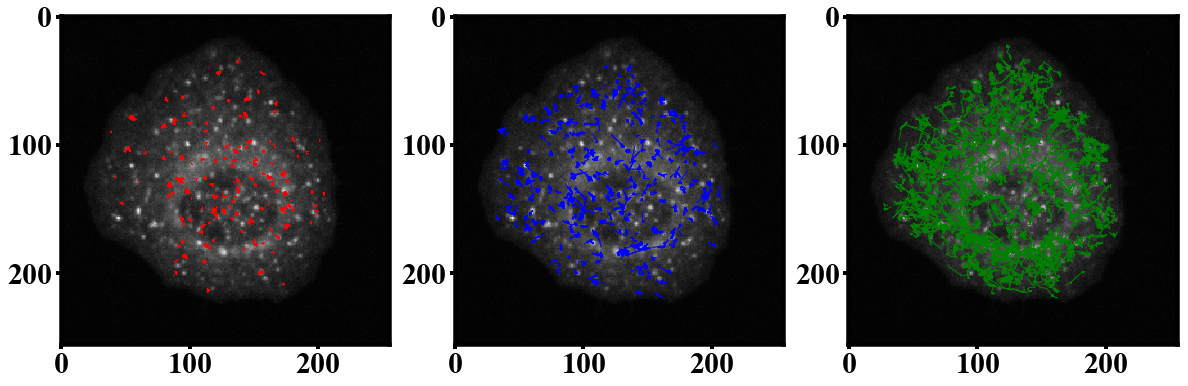

In [24]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(20,20))
ax1.imshow(t_e.getFrame(0))
ax2.imshow(t_e.getFrame(0))
ax3.imshow(t_e.getFrame(0))

for i in t_e.getRealParticles():
    part = t_e.getParticle(i)
    x = part.raw_x_pos
    y = part.raw_y_pos
    if len(x) < 18:
        continue
    color = 'black'
    if part.calcMSD() < 2:
        ax1.plot(y, x, color = 'red', linewidth = 1)
    elif part.calcMSD() < 10:
        ax2.plot(y, x, color = 'blue', linewidth = 1)
    else:
        ax3.plot(y, x, color = 'green', linewidth = 1)
plt.savefig(directory+'mapping_MSD_trajectories.png', transparent = True)

In [44]:
import imageio

def getParticlesFromFrame(frame_num):
    # Need to change t_e to self later
    particles = t_e.getRealParticles()
    parts_in_frame = list()
    for i in particles:
        part = t_e.getParticle(i)
        if frame_num in part.frames:
            parts_in_frame.append(i)
    return parts_in_frame
            
def plotTraceFrame(frame_num):
    image = t_e.plotCurrImage(add_particles=False)
    part_keys = getParticlesFromFrame(frame_num)
    for i in part_keys:
        xs, ys = t_e.getParticle(i).getParticleTrace(frame_num)
        plt.plot(ys, xs)
    return image

def particleTrackingGIF(frame_start, frame_end):
    t_e.curr_frame_num = frame_start
    is_next_frame = True
    gif_data = list()
    while is_next_frame and t_e.curr_frame_num < frame_end:
        print t_e.curr_frame_num
        gif_data.append(plotTraceFrame(t_e.curr_frame_num))
        plt.close()
        is_next_frame = t_e.nextFrame()
    imageio.mimsave(directory+'mapping_gif.gif', gif_data, fps = 32)

In [45]:
particleTrackingGIF(10, 20)

10
11
12
13
14
15
16
17
18
19


ValueError: Image is not numeric, but NoneType.